[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://github.com/CodingPro777/AAI-530-GROUP-1/edit/main/final_project_code.ipynb
)


# USD AAI-530 Group 1 final project - Machine Learning with IoT(FitBit Fitness)

*Group 1 members: Ali Abdul-Hameed, Jack Kim, Jinyuan He*


# 1. Data cleaning & EDA

## 1.1 Loading dataset

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# upload dataset zip file to google drive if not exist
import os
google_drive_path = '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1'

zip_file_path = google_drive_path + '/archive.zip'

if not os.path.isfile(zip_file_path):
  from google.colab import files
  uploaded = files.upload()
  !mv archive.zip '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1'


!unzip '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1/archive.zip'

Archive:  /content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1/archive.zip
replace mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [34]:
# combine two months dataset into one
import pandas as pd

raw_daily_activity_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')]
)

raw_weight_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/weightLogInfo_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv')]
)

raw_hr_sec_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv')]
)

raw_calories_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv')]
)

raw_intensities_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteIntensitiesNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteIntensitiesNarrow_merged.csv')]
)

raw_mets_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteMETsNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteMETsNarrow_merged.csv')]
)

raw_sleep_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv')]
)


raw_step_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteStepsNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteStepsNarrow_merged.csv')]
)

## 1.2 Make up datasets for calories prediction

In [141]:
calories_df = raw_calories_min_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df['ActivityMinute'] = pd.to_datetime(
    calories_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_weight_df['Date'] = pd.to_datetime(
    raw_weight_df['Date'],
    format='%m/%d/%Y %I:%M:%S %p'
)

# sort these two datasets
calories_df = calories_df.sort_values(
    ['ActivityMinute', 'Id']
).reset_index(drop=True)

raw_weight_df = raw_weight_df.sort_values(
    ['Date', 'Id']
).reset_index(drop=True)

calories_merged_df = pd.merge_asof(
    calories_df,
    raw_weight_df[['Id', 'Date', 'WeightPounds', 'BMI']],
    left_on='ActivityMinute',
    right_on='Date',
    by='Id',                # match same user
    direction='backward'    # use latest weight BEFORE activity time
)

In [142]:
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
Date,2296122
WeightPounds,2296122
BMI,2296122


In [143]:
# Forward fill weight-related columns by user
cols_to_fill = ['WeightPounds', 'BMI']

calories_merged_df[cols_to_fill] = (
    calories_merged_df
        .groupby('Id')[cols_to_fill]
        .transform(lambda x: x.ffill().bfill())
)

In [144]:
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
Date,2296122
WeightPounds,1848540
BMI,1848540


In [145]:
# remove the data which doesn't have WeightPounds, BMI
calories_merged_df.dropna(subset=['WeightPounds', 'BMI'], inplace=True)
calories_merged_df.drop(columns=['Date'], inplace=True)
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
WeightPounds,0
BMI,0


In [159]:
number_cols = [
    'Calories',
    'Intensity',
    'METs',
    'Steps',
    'WeightPounds',
    'BMI'
]

calories_merged_df[number_cols] = calories_merged_df[number_cols].apply(pd.to_numeric)

In [160]:
pd.options.display.float_format = '{:.0f}'.format
calories_merged_df.describe()

,Id,ActivityMinute,Calories,Intensity,METs,Steps,WeightPounds,BMI,minute_gap,has_gap
count,1017780,1017780,1017780,1017780,1017780,1017780,1017780,1017780,1017768,1017780
mean,4678242575,2016-04-10 19:26:00.320107008,2,0,15,6,176,28,1,0
min,1503960366,2016-03-12 00:00:00,0,0,0,0,116,21,1,0
25%,2873212765,2016-03-26 17:23:00,1,0,10,0,137,24,1,0
50%,4558609924,2016-04-10 14:02:00,1,0,10,0,167,26,1,0
75%,5577150313,2016-04-25 12:16:00,1,0,12,0,204,28,1,0
max,8877689391,2016-05-12 15:59:00,19,3,157,207,294,48,4381,1
std,2267179456,NaN,1,1,13,19,47,7,4,0


## 1.3 Check minute-level time continuity in the dataset

In [167]:
# Sort by value
calories_merged_df = calories_merged_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
calories_merged_df = calories_merged_df.drop_duplicates(subset=['Id', 'ActivityMinute'])

# Check minute-level time continuity in the dataset
calories_merged_df.groupby('Id')['ActivityMinute'].diff().value_counts().head()

,count
ActivityMinute,
0 days 00:01:00,1017763
0 days 04:01:00,2
3 days 01:01:00,1
0 days 02:01:00,1
0 days 14:01:00,1


#### PS: The minute-level activity data is largely continuous, with over 99% of consecutive records occurring at 1-minute intervals. A small number of duplicate timestamps and occasional multi-hour gaps were observed, likely due to device synchronization or user inactivity.

In [162]:
# We mark time gaps in the data so that the records can be separated into sessions or removed when training time-series models.
calories_merged_df['minute_gap'] = (
    calories_merged_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
      .div(60)
)

calories_merged_df['has_gap'] = (calories_merged_df['minute_gap'] > 1).astype(int)

## 1.4 Data distribution

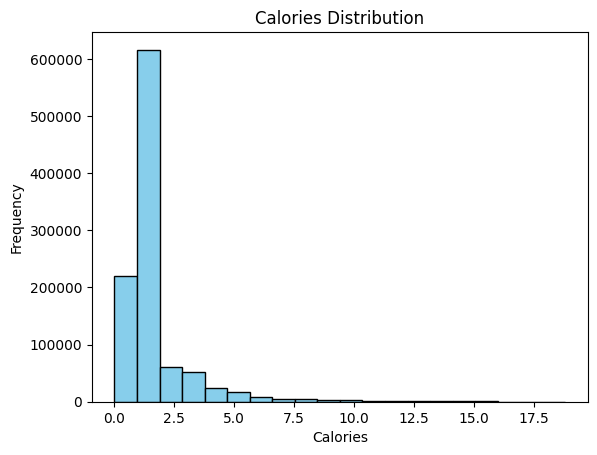

In [172]:
import matplotlib.pyplot as plt

plt.hist(calories_merged_df['Calories'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Calories Distribution')
plt.show()

array([[<Axes: title={'center': 'Steps'}>,
        <Axes: title={'center': 'METs'}>],
       [<Axes: title={'center': 'Intensity'}>, <Axes: >]], dtype=object)

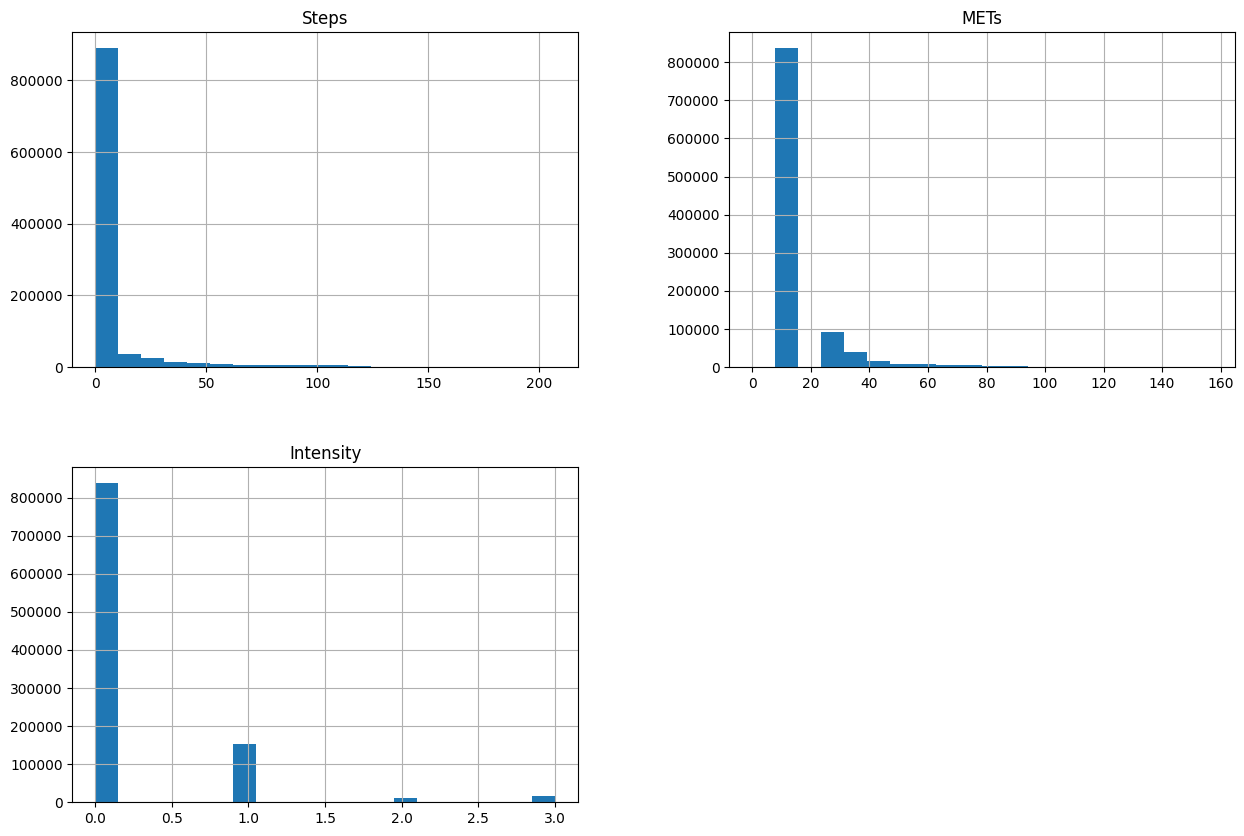

In [181]:
calories_merged_df[['Steps', 'METs', 'Intensity']].hist(bins=20, figsize=(15,10))

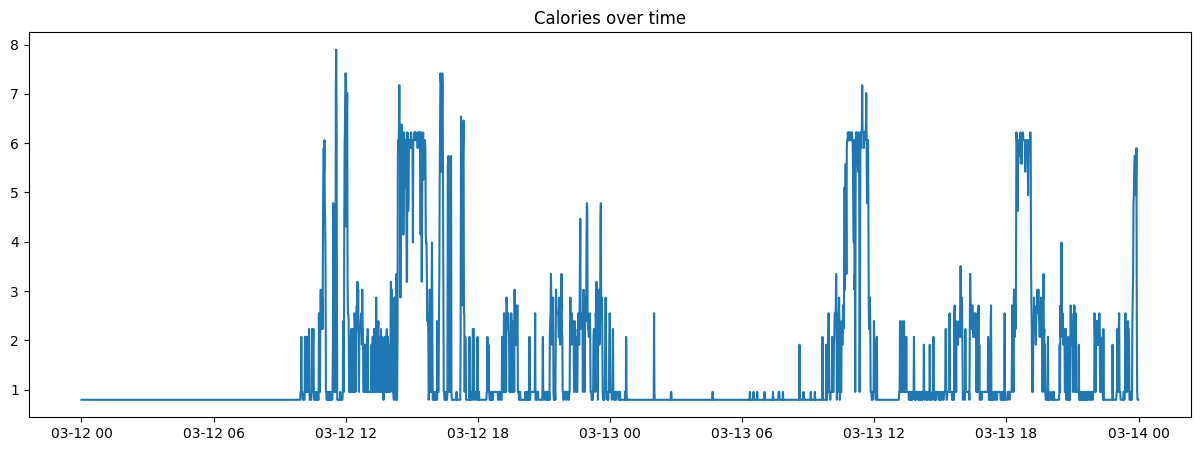

In [193]:
uid = calories_merged_df['Id'].iloc[0]

sample = (
    calories_merged_df[calories_merged_df['Id'] == uid]
        .head(2 * 24 * 60)
)
plt.figure(figsize=(15, 5))
plt.plot(sample['ActivityMinute'], sample['Calories'], label='Calories')
plt.title('Calories over time')
plt.show()

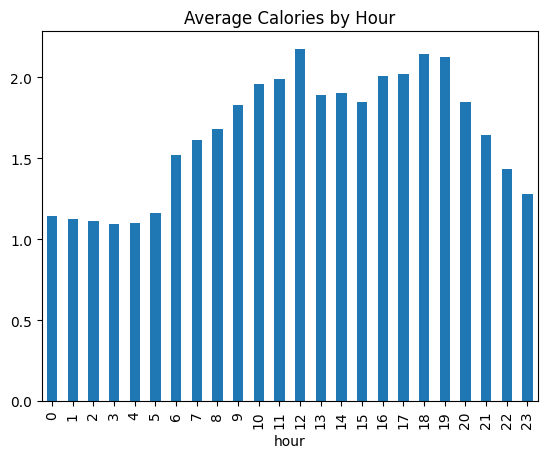

In [194]:
calories_merged_df['hour'] = calories_merged_df['ActivityMinute'].dt.hour

calories_merged_df.groupby('hour')['Calories'].mean().plot(kind='bar')
plt.title('Average Calories by Hour')
plt.show()

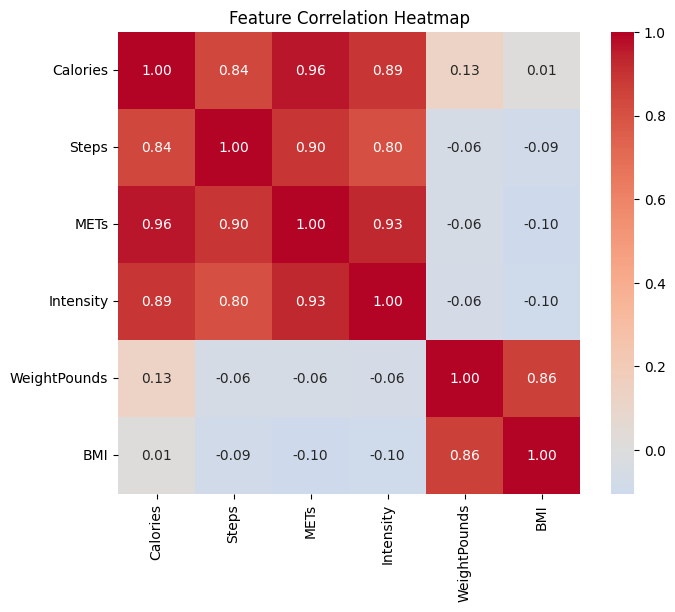

In [200]:
import seaborn as sns
corr = calories_merged_df[
    ['Calories','Steps','METs','Intensity','WeightPounds','BMI']
].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Feature Correlation Heatmap")
plt.show()